In [1]:
%%capture
!wget https://github.com/mtlong2/Datasets/blob/main/disaster_data.zip?raw=true -O disaster_data.zip
!unzip disaster_data
!pip install transformers

In [2]:
# Disaster text classification using BERT
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, AdamW

import numpy as np, pandas as pd
import os

from tqdm import trange

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_path = './bert_disaster_detection_state_dict.pth'
model_path

'./bert_disaster_detection_state_dict.pth'

In [4]:
text = pd.read_csv('./disaster_data/train.csv').text.values
labels = pd.read_csv('./disaster_data/train.csv').target.values
print(text.shape)

(7613,)


([<matplotlib.axis.XTick at 0x7fc13f9bf210>,
 <a list of 2 Text major ticklabel objects>)

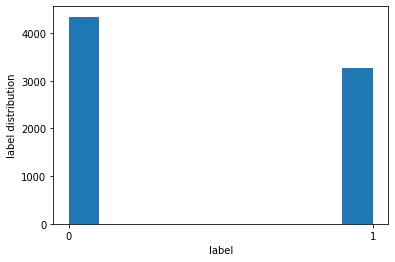

In [5]:
# plot label distribution
plt.hist(labels)
plt.xlabel('label')
plt.ylabel('label distribution')
plt.xticks(np.arange(len(np.unique(labels))))

In [6]:
# prepare data
# Tokenize with BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
padded_seq = tokenizer(list(text), padding=True)
print(f"tokenized inputs {padded_seq['input_ids'][0]}")

tokenized inputs [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
padded_seq.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
# split data into train and validation sets

input_ids = padded_seq['input_ids']
attention_masks = padded_seq['attention_mask']

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=42,
                                                                     test_size=0.10)

train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42,
                                               test_size=0.10)

In [9]:
# convert data into tensors

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [21]:
# create a data interator (generator) for train and validation sets with torch DataLoader
batch_size = 16

# training generator
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

# validation generator
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [11]:
# load pretrained BERT model
# confirm GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
else: print("using CPU")

Tesla T4


In [22]:
# load BertForSequenceClassification (pretrained BERT model with single linear classification layer on top)

num_labels = 2

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# push model to GPU, if available
model.to(device)

# fine-tuning BERT parameters
param_optimizer = list(model.named_parameters())

no_decay = ['bais','gamma','beta']

optimizer_grouped_parameters = [
    {'params': [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
               'weight_decay_rate':0.01},
    {'params' : [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
               'weight_decay_rate':0.0}   
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
if os.path.exists(model_path):
    print ("Loading weights from saved model...")
    model.load_state_dict(torch.load(model_path, map_location=device))

Loading weights from saved model...


In [23]:
# Train Model function

def train(model, iterator, optimizer):
    model.train()
    epoch_loss =0
    
    for step, batch in enumerate(iterator):
        
        # input data
        batch =tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # reset gradients after every batch
        optimizer.zero_grad()
        
        # forward pass
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output['loss']
        
        # backwards pass
        loss.backward()
        
        # take a step using the gradient
        optimizer.step()
        
        #loss
        epoch_loss += loss.item()
        
        if step%100==0:
            print(f"step: {step}")
            
    return epoch_loss / len(iterator)

In [24]:
# Evaluate Model

# calculate accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def evaluate(model, iterator):
    # initialize each epoch
    epoch_accuracy = 0
    
    #deactivate dropout layers in evaluate mode
    model.eval()
    
    for batch in iterator:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # deactivate autograd in evaluat mode
        with torch.no_grad():
            # forward pass, calculate logit predictions before passing through accuracy function
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output['logits']
            
        # move logits and labels to CPU for processing
        # logits = logits.detach().cpu.numpy()
        # label_ids = b_labels.to('cpu').numpy()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        temp_eval_accuracy = flat_accuracy(logits, label_ids)
       
        epoch_accuracy += temp_eval_accuracy
        
    return epoch_accuracy / len(iterator)

In [25]:
# train and validate
num_epochs  = 2
best_val_acc = 0

# BERT training loop
for _ in trange(num_epochs, desc='Epoch'):
    
    # train model
    train_loss = train(model, train_dataloader, optimizer)
    
    # evaluate the model
    val_accuracy = evaluate(model, val_dataloader)
    
    # save the best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        print("saving model...>..>.")
        torch.save(model.state_dict(), model_path)
        
    print(f'\t Training Loss: {train_loss:.3f} | Val. Accuracy: {val_accuracy*100: .2f}%')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

step: 0
step: 100
step: 200
step: 300
step: 400
saving model...>..>.


Epoch:  50%|█████     | 1/2 [02:02<02:02, 122.10s/it]

	 Training Loss: 0.439 | Val. Accuracy:  83.52%
step: 0
step: 100
step: 200
step: 300
step: 400
saving model...>..>.


Epoch: 100%|██████████| 2/2 [04:03<00:00, 121.77s/it]

	 Training Loss: 0.320 | Val. Accuracy:  83.57%


In [29]:
# make predictions

model.to('cpu')
model.load_state_dict(torch.load(model_path))
model.eval()

def prediction(model, sentence):
    encoded_input = tokenizer(sentence, return_tensors="pt")
    output = model(**encoded_input)
    logits = output.logits
    logits = logits.detach().cpu().numpy()
    
    pred = np.argmax(logits, axis=1)[0]
    return 'Disaster event' if pred == 1 else 'Not a disaster event'

In [30]:
prediction(model, "Flash flood in Kamdesh provence")

'Disaster event'

In [33]:
prediction(model, "Great weather to go to the beach")

'Not a disaster event'